In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

In [4]:
import pickle
import numpy as np
from tqdm.auto import trange, tqdm
from features import get_transformer, merge_entries
import json
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from utills import chunker
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV


In [42]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import tikzplotlib
%matplotlib inline

In [5]:
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [47]:
DATA_DIR = '../data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
DATA_PATH = DATA_DIR + 'pan20-authorship-verification-training-large.jsonl'
PREPROCESSED_DATA_PATH = '../temp_data/pan/'
TEMP_DATA_PATH = '../temp_data/pan/'
FIGURES_PATH = '../figures/'

In [18]:
def fit_transformers(data_fraction=0.01):
    docs_1 = []
    docs_2 = []

    with open(PREPROCESSED_DATA_PATH + 'preprocessed_train.jsonl', 'r') as f:
        for l in tqdm(f):
            if np.random.rand() < data_fraction:
                d = json.loads(l)
                docs_1.append(merge_entries(d['pair'][0]))
                docs_2.append(merge_entries(d['pair'][1]))
                
    transformer = get_transformer()
    scaler = StandardScaler()
    secondary_scaler = StandardScaler()

    X = transformer.fit_transform(docs_1 + docs_2).todense()
    X = scaler.fit_transform(X)
    X1 = X[:len(docs_1)]
    X2 = X[len(docs_1):]
    secondary_scaler.fit(np.abs(X1 - X2))
    
    return transformer, scaler, secondary_scaler


def vectorize(XX, Y, ordered_idxs, transformer, scaler, secondary_scaler, preprocessed_path, vector_Sz):
    with open(preprocessed_path, 'r') as f:
        batch_size = 10000
        i = 0;
        docs1 = []
        docs2 = []
        idxs = []
        labels = []
        for l in tqdm(f, total=vector_Sz):
            d = json.loads(l)
            
            docs1.append(merge_entries(d['pair'][0]))
            docs2.append(merge_entries(d['pair'][1]))

            labels.append(ground_truth[d['id']])
            idxs.append(ordered_idxs[i])
            i += 1
            if len(labels) >= batch_size:
                x1 = scaler.transform(transformer.transform(docs1).todense())
                x2 = scaler.transform(transformer.transform(docs2).todense())
                XX[idxs, :] = secondary_scaler.transform(np.abs(x1-x2))
                Y[idxs] = labels

                docs1 = []
                docs2 = []
                idxs = []
                labels = []

        x1 = scaler.transform(transformer.transform(docs1).todense())
        x2 = scaler.transform(transformer.transform(docs2).todense())
        XX[idxs, :] = secondary_scaler.transform(np.abs(x1-x2))
        Y[idxs] = labels
        XX.flush()
        Y.flush()

In [9]:
ground_truth = {}
with open(GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']

In [10]:
train_sz = 0
test_sz = 0

with open(PREPROCESSED_DATA_PATH + 'preprocessed_train.jsonl', 'r') as f:
    for l in f:
        train_sz += 1

with open(PREPROCESSED_DATA_PATH + 'preprocessed_test.jsonl', 'r') as f:
    for l in f:
        test_sz += 1

print('Train Sz:', train_sz, flush=True)
print('Test Sz:', test_sz, flush=True)

Train Sz: 193536
Test Sz: 81963


In [15]:
print('Fitting transformer...', flush=True)
transformer, scaler, secondary_scaler = fit_transformers(data_fraction=0.01)
feature_sz = len(transformer.get_feature_names())

Fitting transformer...


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [16]:
with open(TEMP_DATA_PATH + 'model.p', 'wb') as f:
    pickle.dump((transformer, scaler, secondary_scaler), f)

In [ ]:
print('Vectorizing train set...', flush=True)
XX_train = np.memmap(TEMP_DATA_PATH + 'vectorized_XX_train.npy', dtype='float32', mode='w+', shape=(train_sz, feature_sz))
Y_train = np.memmap(TEMP_DATA_PATH + 'Y_train.npy', dtype='int32', mode='w+', shape=(train_sz))
train_idxs = np.array(range(train_sz))
np.random.shuffle(train_idxs)

vectorize(
    XX_train, 
    Y_train, 
    train_idxs, 
    transformer, 
    scaler, 
    secondary_scaler, 
    PREPROCESSED_DATA_PATH + 'preprocessed_train.jsonl',
    train_sz
)

Vectorizing train set...


In [ ]:
print('Vectorizing test set...', flush=True)
XX_test = np.memmap(TEMP_DATA_PATH + 'vectorized_XX_test.npy', dtype='float32', mode='w+', shape=(test_sz, feature_sz))
Y_test = np.memmap(TEMP_DATA_PATH + 'Y_test.npy', dtype='int32', mode='w+', shape=(test_sz))
test_idxs = np.array(range(test_sz))
np.random.shuffle(test_idxs)

vectorize(
    XX_test, 
    Y_test, 
    test_idxs, 
    transformer, 
    scaler, 
    secondary_scaler, 
    PREPROCESSED_DATA_PATH + 'preprocessed_test.jsonl',
    test_sz
)

Vectorizing test set...


In [27]:
print('Tuning parameters...', flush=True)


param_dist = {'alpha': loguniform(1e-4, 1e0)}
batch_size=10000
clf = SGDClassifier(loss='log', alpha=0.01)
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, verbose=2)
for idxs in chunker(range(train_sz), batch_size):
        random_search.fit(XX_train[idxs, :], Y_train[idxs])
        break

print('Best params:', random_search.best_params_)


Tuning parameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] alpha=0.002130426956292032 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... alpha=0.002130426956292032, total=  13.4s
[CV] alpha=0.002130426956292032 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s


[CV] ....................... alpha=0.002130426956292032, total=   7.8s
[CV] alpha=0.002130426956292032 ......................................
[CV] ....................... alpha=0.002130426956292032, total=   9.5s
[CV] alpha=0.002130426956292032 ......................................
[CV] ....................... alpha=0.002130426956292032, total=  12.3s
[CV] alpha=0.002130426956292032 ......................................
[CV] ....................... alpha=0.002130426956292032, total=  11.7s
[CV] alpha=0.5404150654403683 ........................................
[CV] ......................... alpha=0.5404150654403683, total=   5.9s
[CV] alpha=0.5404150654403683 ........................................
[CV] ......................... alpha=0.5404150654403683, total=   5.3s
[CV] alpha=0.5404150654403683 ........................................
[CV] ......................... alpha=0.5404150654403683, total=   5.9s
[CV] alpha=0.5404150654403683 ........................................
[CV] .

[CV] ......................... alpha=0.3814795176239521, total=   5.4s
[CV] alpha=0.027697150638231353 ......................................
[CV] ....................... alpha=0.027697150638231353, total=   8.8s
[CV] alpha=0.027697150638231353 ......................................
[CV] ....................... alpha=0.027697150638231353, total=   8.7s
[CV] alpha=0.027697150638231353 ......................................
[CV] ....................... alpha=0.027697150638231353, total=   6.4s
[CV] alpha=0.027697150638231353 ......................................
[CV] ....................... alpha=0.027697150638231353, total=   7.6s
[CV] alpha=0.027697150638231353 ......................................
[CV] ....................... alpha=0.027697150638231353, total=   7.7s
[CV] alpha=0.055481967191456455 ......................................
[CV] ....................... alpha=0.055481967191456455, total=   6.0s
[CV] alpha=0.055481967191456455 ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 12.0min finished


Best params: {'alpha': 0.3814795176239521}


In [28]:
print('Best params:', random_search.best_params_)

Best params: {'alpha': 0.3814795176239521}


In [36]:
print('Training classifier...', flush=True)
# clf = SGDClassifier(loss='log', alpha=0.01)
# batch_size=50000
# num_epochs = 50
# aucs = []
for i in trange(num_epochs):
    print('Epoch - ', i)
    print('-' * 30)
    for idxs in chunker(range(train_sz), batch_size):
        clf.partial_fit(XX_train[idxs, :], Y_train[idxs], classes=[0, 1])

    probs = clf.predict_proba(XX_test)[:, 1]
    fpr, tpr, thresh = roc_curve(Y_test, probs)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    print('AUC: ', roc_auc)
    with open(TEMP_DATA_PATH + 'experiment_data.p', 'wb') as f:
        pickle.dump((
            aucs,
            clf,
            roc_auc,
            transformer, 
            scaler,
            secondary_scaler,
            feature_sz,
            train_sz,
            train_idxs,
            test_sz,
            test_idxs
        ), f)

Training classifier...


Epoch -  0
------------------------------
AUC:  0.9690182421800451
Epoch -  1
------------------------------
AUC:  0.9689126771663139
Epoch -  2
------------------------------
AUC:  0.9689380185324076
Epoch -  3
------------------------------
AUC:  0.9689314457145877
Epoch -  4
------------------------------
AUC:  0.9694374426913952
Epoch -  5
------------------------------
AUC:  0.9689141800370734
Epoch -  6
------------------------------
AUC:  0.9690494497636252
Epoch -  7
------------------------------
AUC:  0.9690188710662977
Epoch -  8
------------------------------
AUC:  0.9690604098401971
Epoch -  9
------------------------------
AUC:  0.9695506206960254
Epoch -  10
------------------------------
AUC:  0.9692774963530396
Epoch -  11
------------------------------
AUC:  0.9693552570621218
Epoch -  12
------------------------------
AUC:  0.9692160134559469
Epoch -  13
------------------------------
AUC:  0.9696339529068885
Epoch -  14
------------------------------
AUC:  0.9696279

In [37]:
go.Figure(go.Scatter(
    x=np.arange(len(aucs)),
    y=aucs
))

In [39]:
with open(TEMP_DATA_PATH + 'model.p', 'wb') as f:
    pickle.dump((clf, transformer, scaler, secondary_scaler), f)

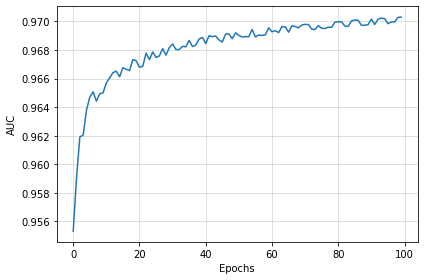

<Figure size 432x288 with 0 Axes>

In [48]:

# style.use('seaborn-white')

fig, ax = plt.subplots()
plt_x = list(range(len(aucs)))
plt_y = aucs
plt.plot(plt_x, plt_y, '-')

plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.grid(True, alpha=0.5)
plt.tight_layout()
# plt.ylim(0.65, 1)
plt.show()

tikzplotlib.save(FIGURES_PATH + 'plt_pan_full_epoch_vs_auc.pgf')